# Support Class for Loss and Evaluation

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq
import matplotlib.pyplot as plt


def roc_auc(labels, scores, show=False):
    """Compute ROC curve and ROC area for each class"""
    # True/False Positive Rates.
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    if show:
        # Equal Error Rate
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        plt.figure()
        lw = 2
        plt.plot(fpr,
                 tpr,
                 color='darkorange',
                 lw=lw,
                 label='(AUC = %0.2f, EER = %0.2f)' % (roc_auc, eer))
        plt.plot([eer], [1 - eer], marker='o', markersize=5, color="navy")
        plt.plot([0, 1], [1, 0], color='navy', lw=1, linestyle=':')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig("roc_auc.png")
        #         plt.close()
    return {'roc_auc': roc_auc}


def pre_rec_curve(labels, scores, show=False):
    average_precision = average_precision_score(labels, scores)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    if show:
        precision, recall, _ = precision_recall_curve(labels, scores)
        step_kwargs = ({
            'step': 'post'
        } if 'step' in signature(plt.fill_between).parameters else {})
        plt.figure()
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall,
                         precision,
                         alpha=0.2,
                         color='b',
                         **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))
        plt.savefig("pre_rec_curve.png")
        #         plt.close()
    return {'average_precision': average_precision}

# Ganomaly V1 Model Skeleton

In [ ]:
import time
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers
#import metrics
from absl import logging


class Conv_BN_Act(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 ks,
                 act_type,
                 is_bn=True,
                 padding='same',
                 strides=1,
                 conv_tran=False):
        super(Conv_BN_Act, self).__init__()
        if conv_tran:
            self.conv = layers.Conv2DTranspose(filters,
                                               ks,
                                               strides=strides,
                                               padding=padding,
                                               use_bias=False)
        else:
            self.conv = layers.Conv2D(filters,
                                      ks,
                                      strides=strides,
                                      padding=padding,
                                      use_bias=False)

        self.is_bn = is_bn
        if is_bn:
            self.bn = layers.BatchNormalization(epsilon=1e-05, momentum=0.9)

        if act_type == 'LeakyReLU':
            self.act = layers.LeakyReLU(alpha=0.2)
            self.erase_act = False
        elif act_type == 'ReLU':
            self.act = layers.ReLU()
            self.erase_act = False
        elif act_type == 'Tanh':
            self.act = layers.Activation(tf.tanh)
            self.erase_act = False
        elif act_type == '':
            self.erase_act = True
        else:
            raise ValueError

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x) if self.is_bn else x
        x = x if self.erase_act else self.act(x)
        return x


class Encoder(tf.keras.layers.Layer):
    """ DCGAN ENCODER NETWORK
    """
    def __init__(self,
                 isize,
                 nz,
                 nc,
                 ndf,
                 n_extra_layers=0,
                 output_features=False):
        """
        Params:
            isize(int): input image size
            nz(int): num of latent dims
            nc(int): num of input dims
            ndf(int): num of discriminator(Encoder) filters
        """
        super(Encoder, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        self.in_block = Conv_BN_Act(filters=ndf,
                                    ks=4,
                                    act_type='LeakyReLU',
                                    is_bn=False,
                                    strides=2)
        csize, cndf = isize / 2, ndf

        self.extra_blocks = []
        for t in range(n_extra_layers):
            extra = Conv_BN_Act(filters=cndf, ks=3, act_type='LeakyReLU')
            self.extra_blocks.append(extra)

        self.body_blocks = []
        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            body = Conv_BN_Act(filters=out_feat,
                               ks=4,
                               act_type='LeakyReLU',
                               strides=2)
            self.body_blocks.append(body)
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        self.output_features = output_features
        self.out_conv = layers.Conv2D(filters=nz,
                                      kernel_size=4,
                                      padding='valid')

    def call(self, x):
        x = self.in_block(x)
        for block in self.extra_blocks:
            x = block(x)
        for block in self.body_blocks:
            x = block(x)
        last_features = x
        out = self.out_conv(last_features)
        if self.output_features:
            return out, last_features
        else:
            return out


class DenseEncoder(tf.keras.layers.Layer):
    def __init__(self, layer_dims, out_size=None, output_features=False, hidden_activation="selu", p_dropout=.2):
        """
        Params:
            layer_dims(Tuple[int]): dense layer dimensions
            out_size(int): overwrite the output size of the last layer; use layer_dims[-1] if None
            output_features(bool): use intermediate activation
            hidden_activation(Union[str,tf.keras.layers.Activation]): activation of the hidden layers
            p_dropout(float): dropout between the hidden layers
        """
        super(DenseEncoder, self).__init__()

        # Config
        self.output_features = output_features

        # Layers
        self.in_block = tf.keras.layers.Dense(layer_dims[0], activation=hidden_activation)
        self.body_blocks = []
        self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))
        for cur_dim in layer_dims[1:-1]:
            self.body_blocks.append(tf.keras.layers.Dense(cur_dim, activation=hidden_activation))
            self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))

        # Override the output dimension if given
        if out_size is not None:
            self.out_act = tf.keras.layers.Dense(out_size)
        else:
            self.out_act = tf.keras.layers.Dense(layer_dims[-1])

    def call(self, x):
        x = self.in_block(x)
        for block in self.body_blocks:
            x = block(x)
        last_features = x
        out = self.out_act(last_features)
        if self.output_features:
            return out, last_features
        else:
            return out


class Decoder(tf.keras.layers.Layer):
    def __init__(self, isize, nz, nc, ngf, n_extra_layers=0):
        """
        Params:
            isize(int): input image size
            nz(int): num of latent dims
            nc(int): num of input dims
            ngf(int): num of Generator(Decoder) filters
        """
        super(Decoder, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"
        cngf, tisize = ngf // 2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        self.in_block = Conv_BN_Act(filters=cngf,
                                    ks=4,
                                    act_type='ReLU',
                                    padding='valid',
                                    conv_tran=True)

        csize, _ = 4, cngf
        self.body_blocks = []
        while csize < isize // 2:
            body = Conv_BN_Act(filters=cngf // 2,
                               ks=4,
                               act_type='ReLU',
                               strides=2,
                               conv_tran=True)
            self.body_blocks.append(body)
            cngf = cngf // 2
            csize = csize * 2

        # Extra layers
        self.extra_blocks = []
        for t in range(n_extra_layers):
            extra = Conv_BN_Act(filters=cngf,
                                ks=3,
                                act_type='ReLU',
                                conv_tran=True)
            self.extra_blocks.append(extra)

        self.out_block = Conv_BN_Act(filters=nc,
                                     ks=4,
                                     act_type='Tanh',
                                     strides=2,
                                     is_bn=False,
                                     conv_tran=True)

    def call(self, x):
        x = self.in_block(x)
        for block in self.body_blocks:
            x = block(x)
        for block in self.extra_blocks:
            x = block(x)
        x = self.out_block(x)
        return x


class DenseDecoder(tf.keras.layers.Layer):
    def __init__(self, isize, layer_dims, hidden_activation="selu", p_dropout=.2):
        """
        Params:
            isize(int): input size
            layer_dims(Tuple[int]): dense layer dimensions
            hidden_activation(Union[str,tf.keras.layers.Activation]): activation of the hidden layers
            p_dropout(float): dropout between the hidden layers
        """
        super(DenseDecoder, self).__init__()

        # Layers
        self.in_block = tf.keras.layers.Dense(layer_dims[0], activation=hidden_activation)
        self.body_blocks = []
        self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))
        for cur_dim in layer_dims[1:]:
            self.body_blocks.append(tf.keras.layers.Dense(cur_dim, activation=hidden_activation))
            self.body_blocks.append(tf.keras.layers.Dropout(p_dropout))

        self.out_block = tf.keras.layers.Dense(isize, activation="tanh")

    def call(self, x):
        x = self.in_block(x)
        for block in self.body_blocks:
            x = block(x)
        x = self.out_block(x)
        return x


class NetG(tf.keras.Model):
    def __init__(self, opt):
        super(NetG, self).__init__()

        # Use the dense encoder-decoder pair when the dimensions are given
        if opt.encdims:
            self.encoder1 = DenseEncoder(opt.encdims)
            self.decoder = DenseDecoder(opt.isize, tuple(reversed(opt.encdims[:-1])))
            self.encoder2 = DenseEncoder(opt.encdims)
        else:
            self.encoder1 = Encoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.extralayers)
            self.decoder = Decoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.extralayers)
            self.encoder2 = Encoder(opt.isize, opt.nz, opt.nc, opt.ngf, opt.extralayers)

    def call(self, x):
        latent_i = self.encoder1(x)
        gen_img = self.decoder(latent_i)
        latent_o = self.encoder2(gen_img)
        return latent_i, gen_img, latent_o

    def num_params(self):
        return sum(
            [np.prod(var.shape.as_list()) for var in self.trainable_variables])


class NetD(tf.keras.Model):
    """ DISCRIMINATOR NETWORK
    """
    def __init__(self, opt):
        super(NetD, self).__init__()

        # Use the dense encoder when the dimensions are given
        if opt.encdims:
            self.encoder = DenseEncoder(opt.encdims, out_size=1, output_features=True)
        else:
            self.encoder = Encoder(opt.isize, 1, opt.nc, opt.ngf, opt.extralayers, output_features=True)

        self.sigmoid = layers.Activation(tf.sigmoid)

    def call(self, x):
        output, last_features = self.encoder(x)
        output = self.sigmoid(output)
        return output, last_features


class GANRunner:
    def __init__(self,
                 G,
                 D,
                 best_state_key,
                 best_state_policy,
                 train_dataset,
                 valid_dataset=None,
                 test_dataset=None,
                 save_path='ckpt/'):
        self.G = G
        self.D = D
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        self.test_dataset = test_dataset
        self.num_ele_train = self._get_num_element(self.train_dataset)
        self.best_state_key = best_state_key
        self.best_state_policy = best_state_policy
        self.best_state = 1e-9 if self.best_state_policy == max else 1e9
        self.save_path = save_path

    def train_step(self, x, y):
        raise NotImplementedError

    def validate_step(self, x, y):
        raise NotImplementedError

    def evaluate(self, x):
        raise NotImplementedError

    def _get_num_element(self, dataset):
        num_elements = 0
        for _ in dataset:
            num_elements += 1
        return num_elements

    def fit(self, num_epoch, best_state_ths=None):
        self.best_state = self.best_state_policy(
            self.best_state,
            best_state_ths) if best_state_ths is not None else self.best_state
        for epoch in range(num_epoch):
            start_time = time.time()
            # train one epoch
            G_losses = []
            D_losses = []
            with tqdm(total=self.num_ele_train, leave=False) as pbar:
                for step, (x_batch_train,
                           y_batch_train) in enumerate(self.train_dataset):
                    loss = self.train_step(x_batch_train, y_batch_train)
                    G_losses.append(loss[0].numpy())
                    D_losses.append(loss[1].numpy())
                    pbar.update(1)
                G_losses = np.array(G_losses).mean()
                D_losses = np.array(D_losses).mean()
                speed = step * len(x_batch_train) / (time.time() - start_time)
                logging.info(
                    'epoch: {}, G_losses: {:.4f}, D_losses: {:.4f}, samples/sec: {:.4f}'
                    .format(epoch, G_losses, D_losses, speed))

            # validate one epoch
            if self.valid_dataset is not None:
                G_losses = []
                D_losses = []
                for step, (x_batch_train,
                           y_batch_train) in enumerate(self.valid_dataset):
                    loss = self.validate_step(x_batch_train, y_batch_train)
                    G_losses.append(loss[0].numpy())
                    D_losses.append(loss[1].numpy())
                G_losses = np.array(G_losses).mean()
                D_losses = np.array(D_losses).mean()
                logging.info(
                    '\t Validating: G_losses: {}, D_losses: {}'.format(
                        G_losses, D_losses))

            # evaluate on test_dataset
            if self.test_dataset is not None:
                dict_ = self.evaluate(self.test_dataset)
                log_str = '\t Testing:'
                for k, v in dict_.items():
                    log_str = log_str + '   {}: {:.4f}'.format(k, v)
                state_value = dict_[self.best_state_key]
                self.best_state = self.best_state_policy(
                    self.best_state, state_value)
                if self.best_state == state_value:
                    log_str = '*** ' + log_str + ' ***'
                    self.save_best()
                logging.info(log_str)

    def save(self, path):
        self.G.save_weights(self.save_path + 'G')
        self.D.save_weights(self.save_path + 'D')

    def load(self, path):
        self.G.load_weights(self.save_path + 'G')
        self.D.load_weights(self.save_path + 'D')

    def save_best(self):
        self.save(self.save_path + 'best')

    def load_best(self):
        self.load(self.save_path + 'best')


class GANomaly(GANRunner):
    def __init__(self,
                 opt,
                 train_dataset,
                 valid_dataset=None,
                 test_dataset=None):
        self.opt = opt
        self.G = NetG(self.opt)
        self.D = NetD(self.opt)
        super(GANomaly, self).__init__(self.G,
                                       self.D,
                                       best_state_key='roc_auc',
                                       best_state_policy=max,
                                       train_dataset=train_dataset,
                                       valid_dataset=valid_dataset,
                                       test_dataset=test_dataset)
        self.D(tf.keras.Input(shape=[opt.isize] if opt.encdims else [opt.isize, opt.isize, opt.nc]))
        self.D_init_w_path = '/tmp/D_init'
        self.D.save_weights(self.D_init_w_path)

        # label
        self.real_label = tf.ones([
            self.opt.batch_size,
        ], dtype=tf.float32)
        self.fake_label = tf.zeros([
            self.opt.batch_size,
        ], dtype=tf.float32)

        # loss
        l2_loss = tf.keras.losses.MeanSquaredError()
        l1_loss = tf.keras.losses.MeanAbsoluteError()
        bce_loss = tf.keras.losses.BinaryCrossentropy()

        # optimizer
        self.d_optimizer = tf.keras.optimizers.Adam(self.opt.lr,
                                                    beta_1=self.opt.beta1,
                                                    beta_2=0.999)
        self.g_optimizer = tf.keras.optimizers.Adam(self.opt.lr,
                                                    beta_1=self.opt.beta1,
                                                    beta_2=0.999)

        # adversarial loss (use feature matching)
        self.l_adv = l2_loss
        # contextual loss
        self.l_con = l1_loss
        # Encoder loss
        self.l_enc = l2_loss
        # discriminator loss
        self.l_bce = bce_loss

    def _evaluate(self, test_dataset):
        an_scores = []
        gt_labels = []
        for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
            latent_i, gen_img, latent_o = self.G(x_batch_train)
            latent_i, gen_img, latent_o = latent_i.numpy(), gen_img.numpy(
            ), latent_o.numpy()
            error = np.mean((latent_i - latent_o)**2, axis=-1)
            an_scores.append(error)
            gt_labels.append(y_batch_train)
        an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
        gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
        return an_scores, gt_labels

    def evaluate(self, test_dataset):
        ret_dict = {}
        an_scores, gt_labels = self._evaluate(test_dataset)
        # normed to [0,1)
        an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) -
                                                        np.amin(an_scores))
        # AUC
        auc_dict = roc_auc(gt_labels, an_scores)
        ret_dict.update(auc_dict)
        # Average Precision
        p_r_dict = pre_rec_curve(gt_labels, an_scores)
        ret_dict.update(p_r_dict)
        return ret_dict

    def evaluate_best(self, test_dataset):
        self.load_best()
        an_scores, gt_labels = self._evaluate(test_dataset)
        # AUC
        _ = roc_auc(gt_labels, an_scores, show=True)
        # Average Precision
        _ = pre_rec_curve(gt_labels, an_scores, show=True)

    @tf.function
    def _train_step_autograph(self, x):
        """ Autograph enabled by tf.function could speedup more than 6x than eager mode.
        """
        self.input = x
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            self.latent_i, self.gen_img, self.latent_o = self.G(self.input)
            self.pred_real, self.feat_real = self.D(self.input)
            self.pred_fake, self.feat_fake = self.D(self.gen_img)
            g_loss = self.g_loss()
            d_loss = self.d_loss()

        g_grads = g_tape.gradient(g_loss, self.G.trainable_weights)
        d_grads = d_tape.gradient(d_loss, self.D.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads,
                                             self.G.trainable_weights))
        self.d_optimizer.apply_gradients(zip(d_grads,
                                             self.D.trainable_weights))
        return g_loss, d_loss

    def train_step(self, x, y):
        g_loss, d_loss = self._train_step_autograph(x)
        if d_loss < 1e-5:
            st = time.time()
            self.D.load_weights(self.D_init_w_path)
            logging.info('re-init D, cost: {:.4f} secs'.format(time.time() -
                                                               st))

        return g_loss, d_loss

    def validate_step(self, x, y):
        pass

    def g_loss(self):
        self.err_g_adv = self.l_adv(self.feat_real, self.feat_fake)
        self.err_g_con = self.l_con(self.input, self.gen_img)
        self.err_g_enc = self.l_enc(self.latent_i, self.latent_o)
        g_loss = self.err_g_adv * self.opt.w_adv + \
                self.err_g_con * self.opt.w_con + \
                self.err_g_enc * self.opt.w_enc
        return g_loss

    def d_loss(self):
        self.err_d_real = self.l_bce(self.pred_real, self.real_label)
        self.err_d_fake = self.l_bce(self.pred_fake, self.fake_label)
        d_loss = (self.err_d_real + self.err_d_fake) * 0.5
        return d_loss

# libraries

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
print(tf.__version__)
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
#from model import GANomaly
from absl import logging
logging.set_verbosity(logging.INFO)
logging.set_stderrthreshold(logging.INFO)

def batch_resize(imgs, size: tuple):
    img_out = np.empty((imgs.shape[0],) + size)
    for i in range(imgs.shape[0]):
        img_out[i] = cv2.resize(imgs[i], size, interpolation=cv2.INTER_CUBIC)
    return img_out

2.4.1


In [ ]:
class Option:
    def __init__(self):
        self.anomaly = 2 # the anomaly digit
        self.shuffle_buffer_size = 10000
        self.batch_size = 300
        self.isize = 32 # input size
        self.ckpt_dir = "ckpt"
        self.nz = 100 # latent dims
        self.nc = 1 # input channels
        self.ndf = 64 # number of discriminator's filters
        self.ngf = 64 # number of generator's filters
        self.extralayers = 0
        self.niter = 15 # number of training epochs
        self.lr = 2e-4 
        self.w_adv = 1. # Adversarial loss weight
        self.w_con = 50. # Reconstruction loss weight
        self.w_enc = 1. # Encoder loss weight.
        self.beta1 = 0.5
        self.encdims = None
            
opt = Option()

In [ ]:
# dataset
data_train, data_test = tf.keras.datasets.mnist.load_data()
x_train, y_train = data_train
x_test, y_test = data_test
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# resize to (32, 32)
x_train = batch_resize(x_train, (32, 32))[..., None]
x_test = batch_resize(x_test, (32, 32))[..., None]
# normalization
mean = x_train.mean()
stddev = x_train.std()
x_train = (x_train-mean)/stddev
x_test = (x_test-mean)/stddev
print(x_train.shape, x_train.shape)
# define abnoraml data and normal
# training data only contains normal
x_train = x_train[y_train!=opt.anomaly]
y_train = y_train[y_train!=opt.anomaly]
y_test = (y_test==opt.anomaly).astype(np.float32)
# tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_dataset = train_dataset.shuffle(opt.shuffle_buffer_size).batch(opt.batch_size, drop_remainder=True)
test_dataset = test_dataset.batch(opt.batch_size, drop_remainder=False)

(60000, 32, 32, 1) (60000, 32, 32, 1)


In [ ]:
ganomaly = GANomaly(opt, train_dataset, valid_dataset=None, test_dataset=test_dataset)

In [ ]:
ganomaly.fit(opt.niter)

INFO:absl:epoch: 0, G_losses: 23.4338, D_losses: 0.7194, samples/sec: 2199.1794


INFO:absl:*** 	 Testing:   roc_auc: 0.2037   average_precision: 0.0608 ***


INFO:absl:epoch: 1, G_losses: 21.3901, D_losses: 0.0697, samples/sec: 3302.4519


INFO:absl:*** 	 Testing:   roc_auc: 0.4730   average_precision: 0.0937 ***


INFO:absl:epoch: 2, G_losses: 17.5077, D_losses: 0.0194, samples/sec: 3365.8735


INFO:absl:*** 	 Testing:   roc_auc: 0.8641   average_precision: 0.3879 ***


INFO:absl:epoch: 3, G_losses: 15.6322, D_losses: 0.0118, samples/sec: 3418.5132


INFO:absl:*** 	 Testing:   roc_auc: 0.9271   average_precision: 0.5738 ***


INFO:absl:epoch: 4, G_losses: 14.5549, D_losses: 0.0083, samples/sec: 3432.0927


INFO:absl:*** 	 Testing:   roc_auc: 0.9288   average_precision: 0.5932 ***


INFO:absl:epoch: 5, G_losses: 13.9233, D_losses: 0.0055, samples/sec: 3408.9680


INFO:absl:	 Testing:   roc_auc: 0.9258   average_precision: 0.5523


INFO:absl:epoch: 6, G_losses: 13.5040, D_losses: 0.0029, samples/sec: 3389.2380


INFO:absl:*** 	 Testing:   roc_auc: 0.9422   average_precision: 0.5672 ***


INFO:absl:epoch: 7, G_losses: 13.2050, D_losses: 0.0027, samples/sec: 3397.2361


INFO:absl:	 Testing:   roc_auc: 0.9348   average_precision: 0.5606


INFO:absl:epoch: 8, G_losses: 12.9727, D_losses: 0.0017, samples/sec: 3411.0396


INFO:absl:	 Testing:   roc_auc: 0.9221   average_precision: 0.5169


INFO:absl:epoch: 9, G_losses: 12.7943, D_losses: 0.0013, samples/sec: 3429.1517


INFO:absl:	 Testing:   roc_auc: 0.9059   average_precision: 0.4790


INFO:absl:epoch: 10, G_losses: 12.6759, D_losses: 0.0011, samples/sec: 3417.3260


INFO:absl:	 Testing:   roc_auc: 0.9242   average_precision: 0.5028


INFO:absl:epoch: 11, G_losses: 12.5517, D_losses: 0.0007, samples/sec: 3417.8754


INFO:absl:	 Testing:   roc_auc: 0.9276   average_precision: 0.5035


INFO:absl:epoch: 12, G_losses: 12.4442, D_losses: 0.0007, samples/sec: 3419.8137


INFO:absl:	 Testing:   roc_auc: 0.9368   average_precision: 0.5147


INFO:absl:epoch: 13, G_losses: 12.3705, D_losses: 0.0005, samples/sec: 3410.3622


INFO:absl:	 Testing:   roc_auc: 0.9229   average_precision: 0.4872


INFO:absl:epoch: 14, G_losses: 12.3025, D_losses: 0.0005, samples/sec: 3418.5978


INFO:absl:	 Testing:   roc_auc: 0.9158   average_precision: 0.4751


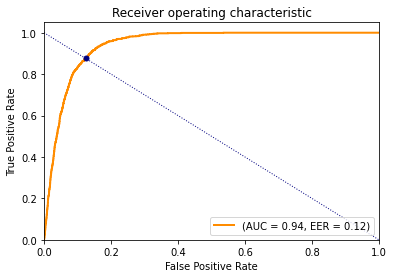

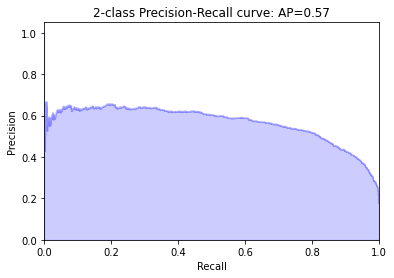

In [ ]:
ganomaly.evaluate_best(test_dataset)